In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from libs.lib import *


d:\ads_test


In [2]:
exps_dir = "../../../exps/exp1"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/data"
os.makedirs(save_dir, exist_ok=True)


In [3]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ads2_prj_VGG16"
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dinhtanloc (nckh_ueh). Use `wandb login --relogin` to force relogin


In [4]:
# Dữ liệu
x_train = pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train = pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test = pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test = pd.read_excel(f'{save_dir}/y_test.xlsx')

In [5]:
from sklearn.metrics import f1_score
import tensorflow as tf
def f1_loss(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
    predicted_positives = tf.reduce_sum(tf.cast(y_pred, tf.float32))
    possible_positives = tf.reduce_sum(tf.cast(y_true, tf.float32))
    
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return 1 - f1

In [6]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    loss = -tf.reduce_mean(alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return loss


In [7]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return 1 - (numerator + 1) / (denominator + 1)


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred, smooth=0.0001):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [9]:
from keras import backend as K

def f1_score(y_true, y_pred):
    """
    F1 score metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

In [26]:
from tensorflow.keras.optimizers.legacy import Adam
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Flatten
from keras.models import Model
from keras.layers import Input
import tensorflow as tf
input_shape =(x_train.shape[1],1)
x_input = Input(shape=input_shape)
dense_units = 1024
learning_rate = 0.0001
kernel_size =3
filter_size=96


# Block 1
x = Conv1D(filter_size, kernel_size, activation='relu', padding='same', name='block1_conv1')(x_input)
x = Conv1D(filter_size, kernel_size, activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling1D(2, strides=2, name='block1_pool')(x)

# Block 2
x = Conv1D(filter_size*2, kernel_size, activation='relu', padding='same', name='block2_conv1')(x)
x = Conv1D(filter_size*2, kernel_size, activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling1D(2, strides=2, name='block2_pool')(x)

# Block 3
x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv1')(x)
x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv2')(x)
x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block3_pool')(x)

# Block 4
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv1')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv2')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block4_pool')(x)

# Block 5
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv1')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv2')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block5_pool')(x)

# x = Flatten(name='flatten')(x)
# x = Dense(dense_units, activation='relu', name='fc1')(x)
# x = Dense(dense_units, activation='relu', name='fc2')(x)
# x = Dense(1, activation='sigmoid', name='predictions')(x)  # Sigmoid for binary classification

# x = GlobalAveragePooling1D()(x)
x = GlobalMaxPooling1D()(x)
# x = Dense(2, activation='softmax', name='predictions')(x)  # Sigmoid for binary classification
x = Dense(1, activation='sigmoid', name='predictions')(x)  # Sigmoid for binary classification

# Create model.
model = Model(x_input, x, name='vgg16')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy',f1_score])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=f1_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=focal_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_loss, metrics=['accuracy',f1_score])
early_stopping = EarlyStopping(monitor='val_accuracy',
    # min_delta=0.00005,
    patience=60,
    verbose=1,
    restore_best_weights=True,
)

checkpointer = ModelCheckpoint(filepath = "Emotion_weights.hdf5",monitor='val_accuracy', verbose = 1, save_best_only=True)


lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.95,
    patience=10,
    min_lr=0.000001,
    verbose=1,
)


In [27]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 34, 1)]           0         
                                                                 
 block1_conv1 (Conv1D)       (None, 34, 96)            384       
                                                                 
 block1_conv2 (Conv1D)       (None, 34, 96)            27744     
                                                                 
 block1_pool (MaxPooling1D)  (None, 17, 96)            0         
                                                                 
 block2_conv1 (Conv1D)       (None, 17, 192)           55488     
                                                                 
 block2_conv2 (Conv1D)       (None, 17, 192)           110784    
                                                                 
 block2_pool (MaxPooling1D)  (None, 8, 192)            0     

In [28]:
def show_pic(times):
    history=model.history.history
    fig,axes=plt.subplots(1,2, figsize=(15,8))
    axes[0].plot(pd.DataFrame(history['val_accuracy']))
    axes[0].set_title('Training Process')
    axes[1].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
    axes[1].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
    axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
    axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
    axes[1].set_title(f'Training Process in {times}')
    axes[1].legend()
    plt.show()


In [29]:
# from sklearn.preprocessing import OneHotEncoder
# import numpy as np

# # Dữ liệu label đã được mã hóa
# def oneHot(arr):
#     labels = np.array(arr)
#     # Khởi tạo một trình chuyển đổi OneHotEncoder
#     encoder = OneHotEncoder(sparse=False)
    
#     # Reshape lại dữ liệu labels để có dạng cột (cần là ma trận 2D)
#     labels_reshaped = labels.reshape(-1, 1)
    
#     # Fit trình chuyển đổi vào dữ liệu
#     encoder.fit(labels_reshaped)
    
#     # Chuyển đổi labels sang dạng one-hot encoding
#     onehot_labels = encoder.transform(labels_reshaped)
#     return onehot_labels

# y_train=oneHot(y_train)
# y_test=oneHot(y_test)

In [30]:
print(y_train.shape)

(19430, 1)


In [31]:
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')


In [32]:
# x_train_, x_validation_,y_train_,y_validation_=train_test_split(x_train,y_train,random_state=42,test_size=0.33)
model.fit(x=x_train,y=y_train,
          validation_data=(x_test,y_test),
          batch_size=32,epochs= 10000, callbacks=[wandb.keras.WandbCallback(),lr_scheduler])

Epoch 1/10000
608/608 [==============================] - ETA: 0s - loss: 0.6221 - accuracy: 0.6121 - f1_score: 0.5604INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240424_175243-efw0ia4v\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240424_175243-efw0ia4v\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240424_175243-efw0ia4v\files\model-best)... Done. 0.3s


608/608 [==============================] - 131s 213ms/step - loss: 0.6221 - accuracy: 0.6121 - f1_score: 0.5604 - val_loss: 0.4864 - val_accuracy: 0.6754 - val_f1_score: 0.2161 - lr: 1.0000e-04
Epoch 2/10000
608/608 [==============================] - 127s 209ms/step - loss: 0.3455 - accuracy: 0.8508 - f1_score: 0.8512 - val_loss: 0.5222 - val_accuracy: 0.7622 - val_f1_score: 0.2153 - lr: 1.0000e-04
Epoch 3/10000
608/608 [==============================] - ETA: 0s - loss: 0.2829 - accuracy: 0.8838 - f1_score: 0.8824INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240424_175243-efw0ia4v\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240424_175243-efw0ia4v\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240424_175243-efw0ia4v\files\model-best)... Done. 0.3s


608/608 [==============================] - 128s 210ms/step - loss: 0.2829 - accuracy: 0.8838 - f1_score: 0.8824 - val_loss: 0.4143 - val_accuracy: 0.8092 - val_f1_score: 0.1905 - lr: 1.0000e-04
Epoch 4/10000
608/608 [==============================] - ETA: 0s - loss: 0.2442 - accuracy: 0.9002 - f1_score: 0.8988INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240424_175243-efw0ia4v\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240424_175243-efw0ia4v\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240424_175243-efw0ia4v\files\model-best)... Done. 0.4s


608/608 [==============================] - 127s 208ms/step - loss: 0.2442 - accuracy: 0.9002 - f1_score: 0.8988 - val_loss: 0.2864 - val_accuracy: 0.8801 - val_f1_score: 0.1559 - lr: 1.0000e-04
Epoch 5/10000
466/608 [=====================>........] - ETA: 28s - loss: 0.2154 - accuracy: 0.9140 - f1_score: 0.9113

KeyboardInterrupt: 

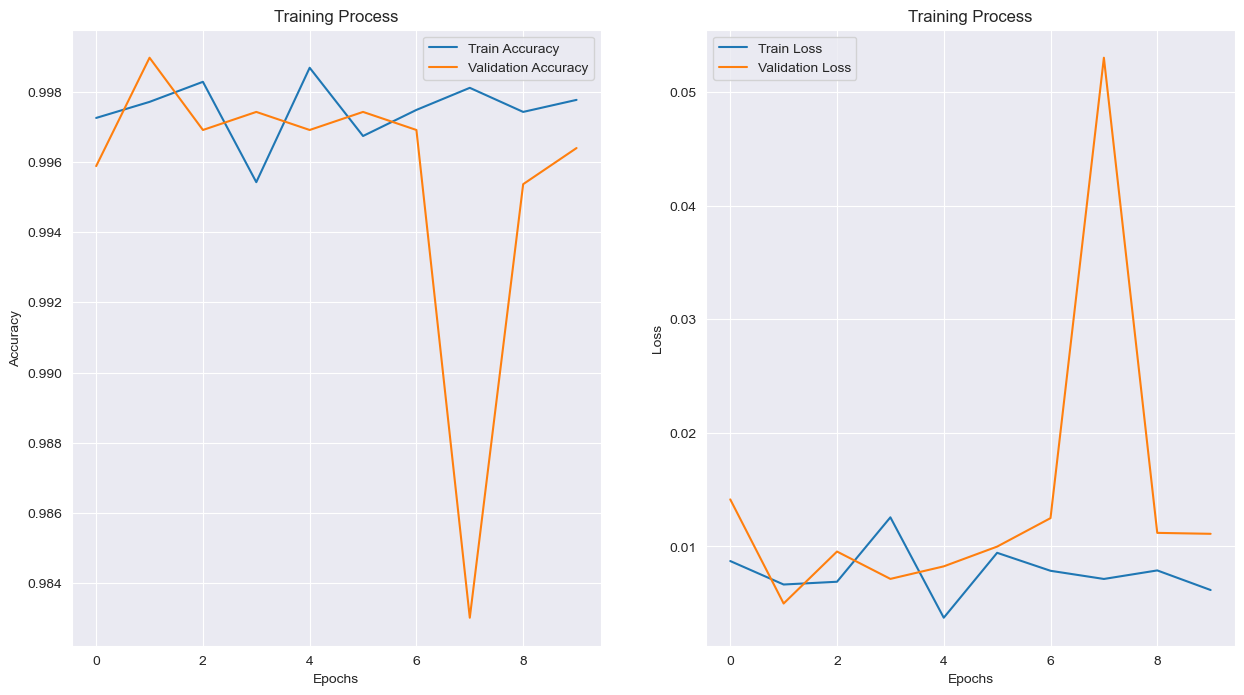

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Lấy dữ liệu từ history
history = model.history.history

# Vẽ biểu đồ
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Biểu đồ accuracy của tập kiểm tra và tập validation
axes[0].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Biểu đồ loss của tập kiểm tra và tập validation
axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Hiển thị biểu đồ
plt.show()

# Lưu biểu đồ vào file
plt.savefig('train.png')


In [ ]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test, predictions)
accuracy

160/160 [==============================] - 2s 14ms/step


0.9396738062487718

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Đánh giá độ chính xác
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Hiển thị báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, predictions,labels=[1,0]))

# # Hiển thị ma trận nhầm lẫn
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.9396738062487718
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       307
           0       0.94      1.00      0.97      4782

    accuracy                           0.94      5089
   macro avg       0.47      0.50      0.48      5089
weighted avg       0.88      0.94      0.91      5089



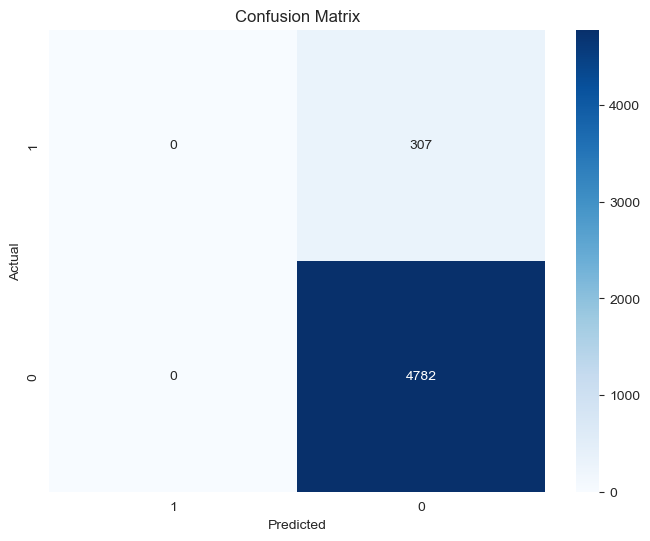

In [ ]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

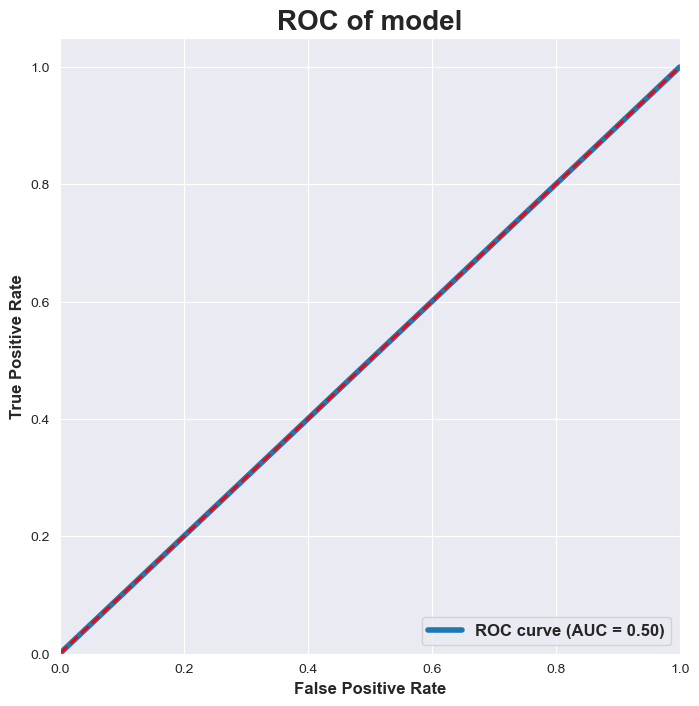

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, predictions,ax,name='model'):    
    # Tính toán FPR và TPR từ decision function
    fpr, tpr, _ = roc_curve(y_test, predictions)
    
    # Tính diện tích dưới đường cong ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường cong ROC
    ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
    ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
    ax.set_title(f'ROC of {name}',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
    ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})  # Đặt kích thước và độ dày cho chú thích

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

plot_roc_curve(y_test,predictions,axes)
# predictions

In [ ]:
def check_result(prediction):
    prediction = (prediction > 0.5).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [ ]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    y_predict = predictions
    #print(y_predict[0][0])
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(y_predict[indx]))
    print("----------------------------")
    if Y_check==check_result(y_predict[indx]):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1
    

True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------


In [ ]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['FraudFound_P']==1]))*100}% so với thực tế")

Số lần dự đoán đúng: 4782 chiếm khoảng 93.96738062487718% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 0 chiếm khoảng 0.0% so với thực tế
